In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [8]:
#Load data
df = pd.read_csv('/Users/ellenwu/homework5-1/data/output/acs_medicaid.csv')

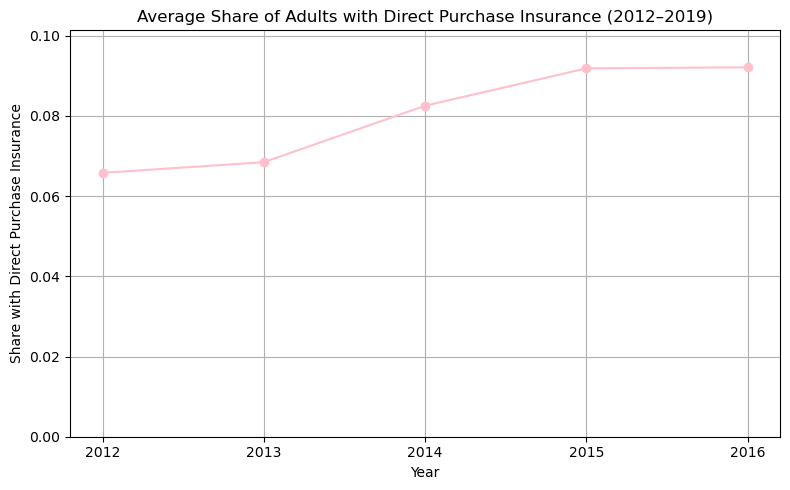

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned ACS data
df = pd.read_csv("/Users/ellenwu/homework5-1/data/output/acs_medicaid.csv")

# Drop rows where adult population or direct insurance values are missing or zero
df = df[df['adult_pop'].notna() & df['ins_direct'].notna()]
df = df[df['adult_pop'] > 0]

# Calculate share of direct-purchase insurance
df['share_direct'] = df['ins_direct'] / df['adult_pop']

# Filter out any rows where the share is missing or invalid
df = df[df['share_direct'].notna() & df['share_direct'].apply(lambda x: x != float('inf'))]

# Group by year to calculate the average share
trend = df.groupby('year', as_index=False)['share_direct'].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(trend['year'], trend['share_direct'], marker='o', linestyle='-', color='pink')
plt.title("Average Share of Adults with Direct Purchase Insurance (2012–2019)")
plt.xlabel("Year")
plt.ylabel("Share with Direct Purchase Insurance")
plt.ylim(0, trend['share_direct'].max() * 1.1 if not trend['share_direct'].isna().all() else 0.05)
plt.grid(True)
plt.xticks(ticks=trend['year'], labels=trend['year'])
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd

df = pd.read_csv("/Users/ellenwu/homework5-1/data/output/acs_medicaid.csv", sep="\t")
print(df.columns.tolist())

['State,year,adult_pop,ins_employer,ins_direct,ins_medicare,ins_medicaid,uninsured,expand_ever,expand_year,expand']
